In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.stats import norm
import warnings
import os 
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('IR Data.xlsx', sheet_name = 'Swaption',header = 2)
###tenor conversion
data['Tenor'] = data['Tenor'].str.extract('(\d+)')
data.Tenor = data.Tenor.astype(float)
data.loc[data['Tenor'] == 99,'Tenor'] = 0.5

###expiry conversion
data['Expiry'] = data['Expiry'].str.extract('(\d+)')
data.Expiry = data.Expiry.astype(float)
data.loc[data['Expiry'] == 99,'Expiry'] = 0.5

data

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1.0,1.0,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1.0,2.0,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1.0,3.0,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1.0,5.0,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1.0,10.0,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5.0,1.0,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5.0,2.0,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5.0,3.0,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5.0,5.0,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5.0,10.0,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [3]:
data_forward = pd.read_csv('forward_swap.csv', index_col = 0)
data['forward_swap'] = data_forward['forward_swap']
data

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,forward_swap
0,1.0,1.0,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297,0.032007
1,1.0,2.0,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523,0.033259
2,1.0,3.0,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833,0.034011
3,1.0,5.0,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165,0.035255
4,1.0,10.0,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355,0.038424
5,5.0,1.0,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980,0.039274
6,5.0,2.0,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760,0.040075
7,5.0,3.0,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150,0.040068
8,5.0,5.0,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400,0.041087
9,5.0,10.0,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250,0.043612


### Black76 Model

Black-Scholes Call Option Formula

\\( C(S,K,r,\sigma,T)= S_0  \Phi(d_1) - K e^{-rT} \Phi(d_2)\\)

where \\(d_1=(\frac{\log \frac{S_0}{K} +
            \left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}), \hspace{2cm} d_2 =d_1 - \sigma\sqrt{T}\\)

In [4]:
def BlackScholesCall_Vanilla(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [5]:
def BlackScholesPut_Vanilla(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [6]:
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/sigma*sqrt(T)
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def call_delta( S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
def call_rho(S,K,T,r,sigma):
    return 0.01*(K*T*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
  
  ## define the Put_Greeks of an option
def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
def put_rho(S,K,T,r,sigma):
    return 0.01*(-K*T*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))

In [7]:
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'c'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesCall_Vanilla(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'p'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesPut_Vanilla(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol



### Displaced-Diffusion Model

In [8]:
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    disc = np.exp(-r*T)
    return disc*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    disc = np.exp(-r*T)
    return disc*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))


### Sabr

In [9]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma



## Calibration DD Model

In [10]:
def calibrationdd(x, S, strikes, r, vols, volatility,T):
    err = 0.0
    
    for i, vol in enumerate(vols):
        if strikes[i] <= 0:
            price = DisplacedDiffusionPut(S, strikes[i], r, volatility, T, x[0])
            err += (vol - impliedVolatility(S, strikes[i], r, price, T,'p'))**2
        elif strikes[i]>0:
            price = DisplacedDiffusionCall(S, strikes[i], r, volatility, T, x[0])
            err += (vol - impliedVolatility(S, strikes[i], r, price, T,'c'))**2
    return err

In [11]:
strike_list = np.array([-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02])
initialGuess_dd_beta = [0.1]
#assume r = 0.01
r = 0.00

In [12]:
for i in data.Expiry.unique():
    for j in data.Tenor.unique():             
        sigma = data.loc[  (data.Expiry == i)& (data.Tenor == j)]['ATM'].values[0]/100
        T = i
        F = data.loc[  (data.Expiry == i)& (data.Tenor == j)]['forward_swap'].values[0]
        strikes = strike_list + F
        res = least_squares(lambda x: calibrationdd(x,
                                            S=F,
                                            strikes=strikes,
                                            r=r,                                          
                                            vols = (data.loc[(data.Expiry == i)& (data.Tenor == j)][["-200bps","-150bps","-100bps","-50bps","-25bps","ATM","+25bps","+50bps","+100bps","+150bps","+200bps"]].values[0]/ 100) ,
                                            volatility = sigma,                                                    
                                            T=T),
                    initialGuess_dd_beta,bounds=([0.0000001, 1]))
        data.loc[(data.Expiry == i)& (data.Tenor == j),'dd_beta'] = res.x[0]

### Sabr

In [13]:
initialGuess_sabr_alpha_rho_nu = [0.3, -0.3, 1.2]

In [14]:
SABR_beta = 0.9

In [15]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], SABR_beta, x[1], x[2]))**2

    return err

In [16]:
for i in data.Expiry.unique():
    for j in data.Tenor.unique():             
        iv = data.loc[  (data.Expiry == i)& (data.Tenor == j)]['ATM'].values[0]
        T = i
        F = data.loc[  (data.Expiry == i)& (data.Tenor == j)]['forward_swap'].values[0]
        strikes = strike_list + F
        res = least_squares(lambda x: sabrcalibration(x,
                                            strikes=strikes,                                        
                                            vols = (data.loc[(data.Expiry == i)& (data.Tenor == j)][["-200bps","-150bps","-100bps","-50bps","-25bps","ATM","+25bps","+50bps","+100bps","+150bps","+200bps"]].values[0]/ 100) ,
                                            F=F,
                                            T=T),
                    initialGuess_sabr_alpha_rho_nu,max_nfev=500)
        data.loc[  (data.Expiry == i)& (data.Tenor == j),'sabr_alpha'] = res.x[0]
        data.loc[  (data.Expiry == i)& (data.Tenor == j),'sabr_beta'] = SABR_beta
        data.loc[  (data.Expiry == i)& (data.Tenor == j),'sabr_rho'] = res.x[1]
        data.loc[  (data.Expiry == i)& (data.Tenor == j),'sabr_nu'] = res.x[2]

In [17]:
data.to_csv(os.getcwd() + r'\sabr_dd.csv')
data

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,forward_swap,dd_beta,sabr_alpha,sabr_beta,sabr_rho,sabr_nu
0,1.0,1.0,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297,0.032007,1.113968e-06,0.140424,0.9,-0.627410,2.025269
1,1.0,2.0,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523,0.033259,1.001583e-07,0.184880,0.9,-0.524942,1.674807
2,1.0,3.0,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833,0.034011,1.009063e-07,0.197018,0.9,-0.483090,1.436583
3,1.0,5.0,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165,0.035255,1.027665e-07,0.177524,0.9,-0.411593,1.070230
4,1.0,10.0,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355,0.038424,2.205785e-05,0.168069,0.9,-0.237839,0.817103
5,5.0,1.0,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980,0.039274,1.011071e-07,0.166129,0.9,-0.582356,1.334673
6,5.0,2.0,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760,0.040075,2.087522e-07,0.199469,0.9,-0.546637,1.061593
7,5.0,3.0,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150,0.040068,1.193296e-06,0.210170,0.9,-0.549103,0.936512
8,5.0,5.0,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400,0.041087,1.662737e-05,0.186872,0.9,-0.487205,0.686964
9,5.0,10.0,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250,0.043612,5.794592e-02,0.168234,0.9,-0.358823,0.556587


## Swap

In [18]:
from scipy import interpolate

In [19]:
df_df = pd.read_csv('data_semi.csv')
df_df.head()

,Unnamed: 0,Tenor,Rate,float,OIS_Discount,lbs_rate,lbs_Discount,forward_libor
0,0,0.5,0.00250,0.002497,0.998752,0.025,0.987654,0.025000
1,1,1.0,0.00300,0.002996,0.997009,0.028,0.972577,0.031005
2,2,1.5,NaN,0.003495,0.995268,NaN,0.957378,0.031751
3,3,2.0,0.00325,0.003495,0.993531,0.030,0.942179,0.032263
4,4,2.5,NaN,0.003545,0.991771,NaN,0.926330,0.034218


In [20]:
def pv_func(expiry, tenor, payment,df):
    pv = 0.0
    delta_t = np.arange(expiry + payment, expiry + tenor + 0.1, payment)
    for i in delta_t:
        pv = pv + df[df['Tenor'] == i].OIS_Discount.values
    return pv * payment

In [21]:
def Black76Pay(F, K, T, sigma):
    d1 = (np.log(F / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (F * norm.cdf(d1) - K * norm.cdf(d2))

def Black76Rec(F, K, T, sigma):
    d1 = (np.log(F / K) + (sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (K * norm.cdf(-d2) - F * norm.cdf(-d1))

In [22]:
def interpolate_func(x_list,y_list,x_new):
    y_interp = interpolate.interp1d(x_list, y_list)
    value = y_interp(x_new)
    return float(value)

In [23]:
data_forward_6m = pd.read_csv('forward_swap_6m.csv', index_col = 0)
data_forward_6m

,Expiry,Tenor,forward_swap
0,0.5,1,0.028000
1,0.5,2,0.030000
2,0.5,3,0.031500
3,0.5,5,0.033000
4,0.5,10,0.037000
5,1.0,1,0.032007
6,1.0,2,0.033259
7,1.0,3,0.034011
8,1.0,5,0.035255
9,1.0,10,0.038424


# Payer

## Generate Sabr Vol matrix

In [24]:
#interpolate sabr variables
alpha_2y_10y = interpolate_func([1,5], [ data.loc[  (data.Expiry == 1)& (data.Tenor == 10)]['sabr_alpha'].values[0],  data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['sabr_alpha'].values[0]] , 2)
rho_2y_10y = interpolate_func([1,5], [ data.loc[  (data.Expiry == 1)& (data.Tenor == 10)]['sabr_rho'].values[0],  data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['sabr_rho'].values[0]] , 2)
nu_2y_10y = interpolate_func([1,5], [ data.loc[  (data.Expiry == 1)& (data.Tenor == 10)]['sabr_nu'].values[0],  data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['sabr_nu'].values[0]] , 2)
atm_2yr_10_yr = data_forward_6m.loc[  (data_forward_6m.Expiry == 2)& (data_forward_6m.Tenor == 10)]['forward_swap'].values[0]

#get sabr model
strikes_2yr_10yr = np.arange(0.01,0.081,0.01)

sabr_vol_list_2yr_10yr = np.array([SABR(F=atm_2yr_10_yr, K=x, T=2, alpha=alpha_2y_10y, beta=0.9, rho=rho_2y_10y, nu=nu_2y_10y) for x in strikes_2yr_10yr])
black_payer = Black76Pay(atm_2yr_10_yr, K=strikes_2yr_10yr, T=2, sigma = sabr_vol_list_2yr_10yr)

sabr_2yr_10yr_swaption_payer = pv_func(2, 10, 0.5,df_df)*black_payer
sabr_2yr_10yr_swaption_payer

array([0.29041974, 0.19893237, 0.11514663, 0.05158352, 0.02178362,
       0.01177343, 0.00777111, 0.00575918])

# Generate DD vol matrix

In [25]:
beta_2y_10y = interpolate_func([1,5], [ data.loc[  (data.Expiry == 1)& (data.Tenor == 10)]['dd_beta'].values[0],  data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['dd_beta'].values[0]] , 2)
###assume the volatility is also interpolatable
sigma_2yr_10yr = interpolate_func([1,5], [ data.loc[  (data.Expiry == 1)& (data.Tenor == 10)]['ATM'].values[0],  data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['ATM'].values[0]] , 2)

#strikes
strikes_2yr_10yr = np.arange(0.01,0.081,0.01)
dd_vol_list_2yr_10yr = np.array([DisplacedDiffusionCall(S=atm_2yr_10_yr, K=x, r=0.01, sigma=sigma_2yr_10yr, T=2, beta=beta_2y_10y) for x in strikes_2yr_10yr])
black_payer = Black76Pay(atm_2yr_10_yr, K=strikes_2yr_10yr, T=2, sigma = dd_vol_list_2yr_10yr)
dd_2yr_10yr_swaption_payer = pv_func(2, 10, 0.5,df_df)*black_payer
dd_2yr_10yr_swaption_payer

array([0.29024719, 0.21195857, 0.15461416, 0.1136493 , 0.08431322,
       0.06309931, 0.04758791, 0.03612594])

# Receiver

In [26]:
#interpolate sabr variables
alpha_8y_10y = interpolate_func([5,10], [ data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['sabr_alpha'].values[0],  data.loc[  (data.Expiry == 10)& (data.Tenor == 10)]['sabr_alpha'].values[0]] , 8)
rho_8y_10y = interpolate_func([5,10], [ data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['sabr_rho'].values[0],  data.loc[  (data.Expiry == 10)& (data.Tenor == 10)]['sabr_rho'].values[0]] , 8)
nu_8y_10y = interpolate_func([5,10], [ data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['sabr_nu'].values[0],  data.loc[  (data.Expiry == 10)& (data.Tenor == 10)]['sabr_nu'].values[0]] , 8)
atm_8yr_10_yr = data_forward_6m.loc[  (data_forward_6m.Expiry == 8)& (data_forward_6m.Tenor == 10)]['forward_swap'].values[0]

#get sabr model
strikes_8yr_10yr = np.arange(0.01,0.081,0.01)

sabr_vol_list_8yr_10yr = np.array([SABR(F=atm_8yr_10_yr, K=x, T=8, alpha=alpha_8y_10y, beta=0.9, rho=rho_8y_10y, nu=nu_8y_10y) for x in strikes_8yr_10yr])
black_receiver = Black76Rec(atm_8yr_10_yr, K=strikes_8yr_10yr, T=8, sigma = sabr_vol_list_8yr_10yr)

sabr_8yr_10yr_swaption_rec = pv_func(8, 10, 0.5,df_df)*black_receiver
sabr_8yr_10yr_swaption_rec

array([0.02164013, 0.04121173, 0.06341091, 0.09167504, 0.13174908,
       0.18982134, 0.26448902, 0.34865878])

In [27]:
beta_8y_10y = interpolate_func([5,10], [ data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['dd_beta'].values[0],  data.loc[  (data.Expiry == 10)& (data.Tenor == 10)]['dd_beta'].values[0]] , 8)
###assume the volatility is also interpolatable
sigma_8yr_10yr = interpolate_func([5,10], [ data.loc[  (data.Expiry == 5)& (data.Tenor == 10)]['ATM'].values[0],  data.loc[  (data.Expiry == 10)& (data.Tenor == 10)]['ATM'].values[0]] , 8)

#strikes
strikes_8yr_10yr = np.arange(0.01,0.081,0.01)
dd_vol_list_8yr_10yr = np.array([DisplacedDiffusionCall(S=atm_8yr_10_yr, K=x, r=0.01, sigma=sigma_8yr_10yr, T=2, beta=beta_8y_10y) for x in strikes_8yr_10yr])
black_receiver = Black76Rec(atm_8yr_10_yr, K=strikes_8yr_10yr, T=2, sigma = dd_vol_list_8yr_10yr)
dd_8yr_10yr_swaption_rec = pv_func(8, 10, 0.5,df_df)*black_receiver
dd_8yr_10yr_swaption_rec

array([0.00335074, 0.02330308, 0.06066068, 0.11136076, 0.17188398,
       0.23967429, 0.31291937, 0.39032461])

In [28]:
df_answers = pd.DataFrame()
df_answers = df_answers.append([sabr_2yr_10yr_swaption_payer,dd_2yr_10yr_swaption_payer,sabr_8yr_10yr_swaption_rec,dd_8yr_10yr_swaption_rec])
df_answers = df_answers.rename({0: '1%', 1: '2%',2:"3%",3:"4%",4:"5%",5:"6%",6:"7%",7:"8%"}, axis='columns')
df_answers = df_answers.rename(index={0: 'sabr_2yr_10yr_swaption_payer',1:"dd_2yr_10yr_swaption_payer",2:"sabr_8yr_10yr_swaption_rec",3:"dd_8yr_10yr_swaption_rec"})
df_answers

,1%,2%,3%,4%,5%,6%,7%,8%
sabr_2yr_10yr_swaption_payer,0.290420,0.198932,0.115147,0.051584,0.021784,0.011773,0.007771,0.005759
dd_2yr_10yr_swaption_payer,0.290247,0.211959,0.154614,0.113649,0.084313,0.063099,0.047588,0.036126
sabr_8yr_10yr_swaption_rec,0.021640,0.041212,0.063411,0.091675,0.131749,0.189821,0.264489,0.348659
dd_8yr_10yr_swaption_rec,0.003351,0.023303,0.060661,0.111361,0.171884,0.239674,0.312919,0.390325


# Chart

<AxesSubplot:title={'center':'Swaption Prices'}>

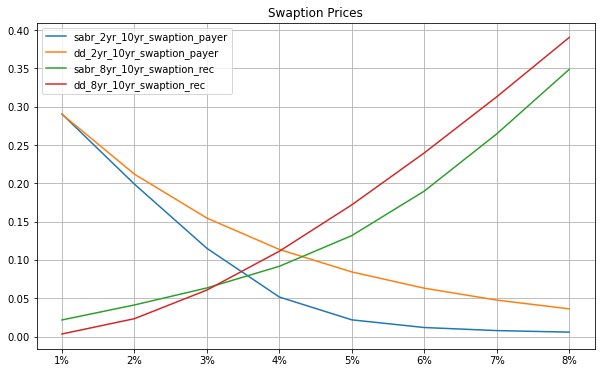

In [29]:
df_answers.T.plot(figsize = (10,6),title='Swaption Prices', grid = True)

In [30]:
df_sabr_data = data.copy(deep = True)
df_dd_data = data.copy(deep = True)
strike_list = np.array([-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02])
columns_fill = ["-200bps","-150bps","-100bps","-50bps","-25bps","ATM","+25bps","+50bps","+100bps","+150bps","+200bps"]
##generate sabr vol
for i in range(len(strike_list)):
    for j in range(len(df_sabr_data)):
        df_sabr_data.iloc[j][columns_fill[i]] = SABR(df_sabr_data.iloc[j]['forward_swap'], 
             strike_list[i]+df_sabr_data.iloc[j]['forward_swap'], 
             df_sabr_data.iloc[j]['Expiry'], 
             df_sabr_data.iloc[j]['sabr_alpha'], 
             df_sabr_data.iloc[j]['sabr_beta'], 
             df_sabr_data.iloc[j]['sabr_rho'], 
             df_sabr_data.iloc[j]['sabr_nu'])
##generate dd vol
df_dd_data['dd_sigma'] = data['ATM']
for i in range(len(strike_list)):    
    if i<5:
        for j in range(len(df_dd_data)):
            price_dd = DisplacedDiffusionPut(S=df_dd_data.iloc[j]['forward_swap'], K=df_dd_data.iloc[j]['forward_swap']+strike_list[i], r=0.01, sigma=df_dd_data.iloc[j]['dd_sigma']/100, T=df_dd_data.iloc[j]['Expiry'], beta=df_dd_data.iloc[j]['dd_beta'])
            iv = impliedVolatility(S=df_dd_data.iloc[j]['forward_swap'], K=df_dd_data.iloc[j]['forward_swap']+strike_list[i], r=0.01, price=price_dd, T=df_dd_data.iloc[j]['Expiry'], payoff='p')
            df_dd_data.loc[df_dd_data.index==j,columns_fill[i]] = iv
            
    elif i>=5:
        for j in range(len(df_dd_data)):
            price_dd = DisplacedDiffusionCall(S=df_dd_data.iloc[j]['forward_swap'], K=df_dd_data.iloc[j]['forward_swap']+strike_list[i], r=0.01, sigma=df_dd_data.iloc[j]['dd_sigma']/100, T=df_dd_data.iloc[j]['Expiry'], beta=df_dd_data.iloc[j]['dd_beta'])
            iv = impliedVolatility(S=df_dd_data.iloc[j]['forward_swap'], K=df_dd_data.iloc[j]['forward_swap']+strike_list[i], r=0.01, price=price_dd, T=df_dd_data.iloc[j]['Expiry'], payoff='c')
            df_dd_data.loc[df_dd_data.index==j,columns_fill[i]] = iv


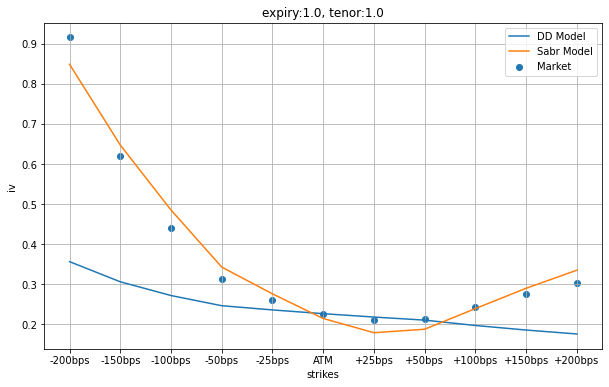

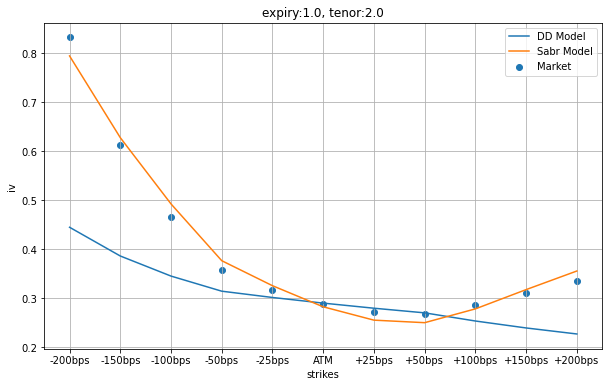

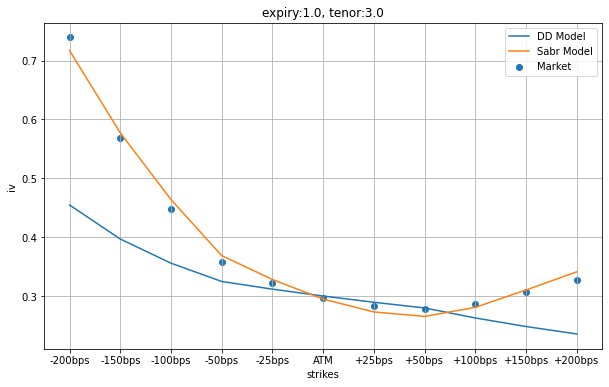

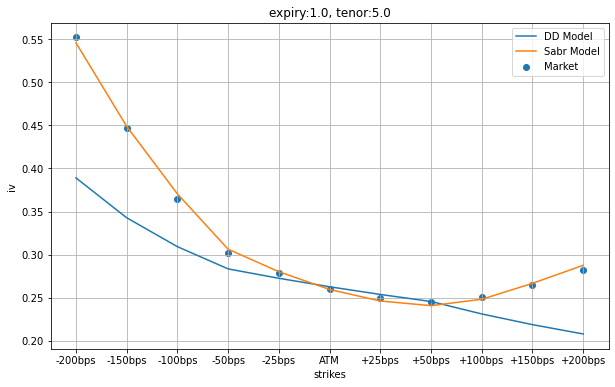

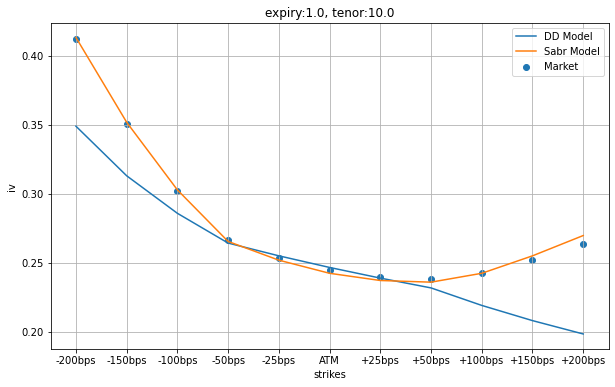

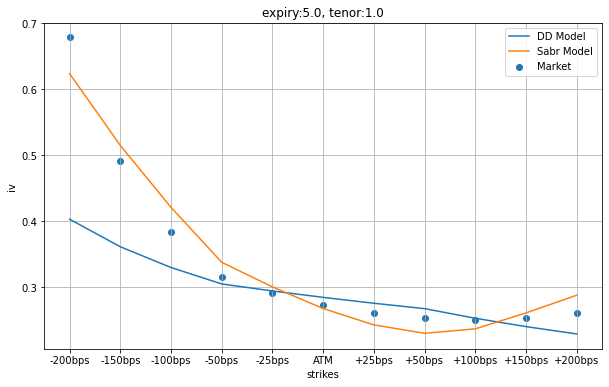

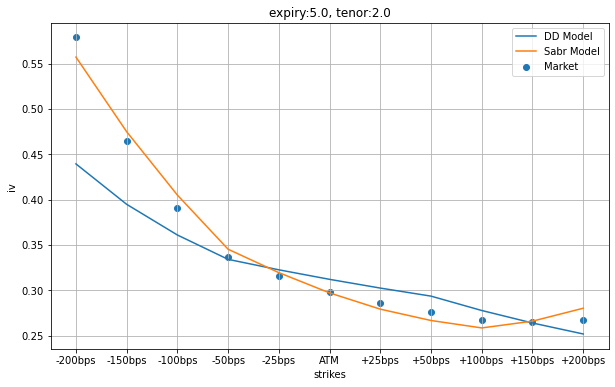

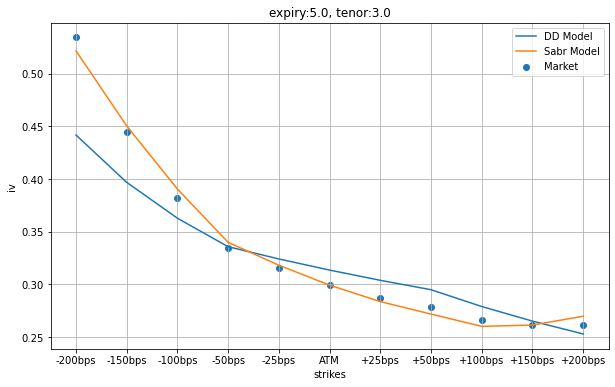

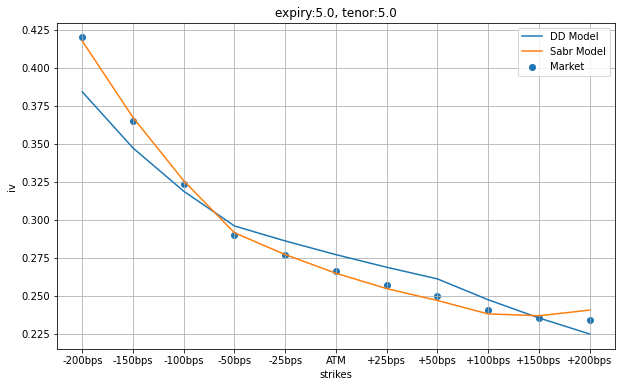

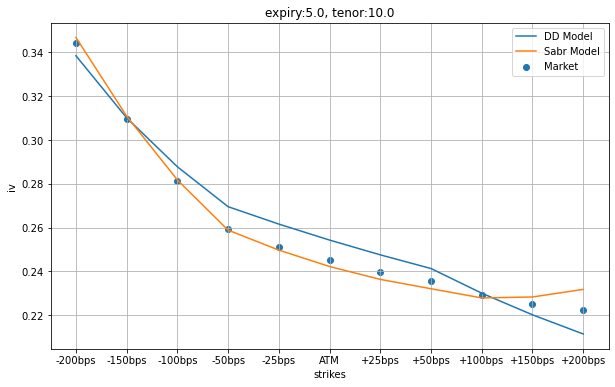

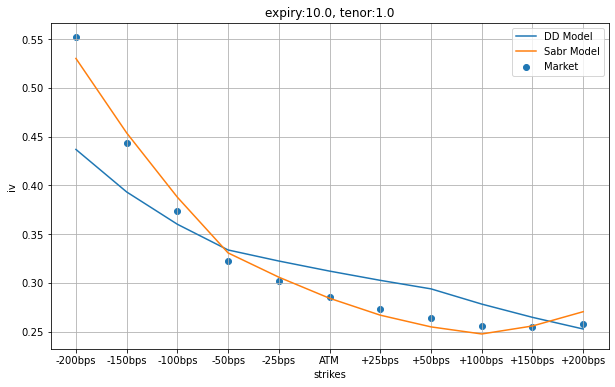

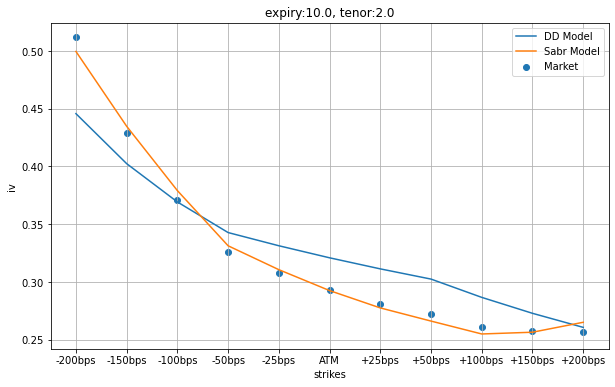

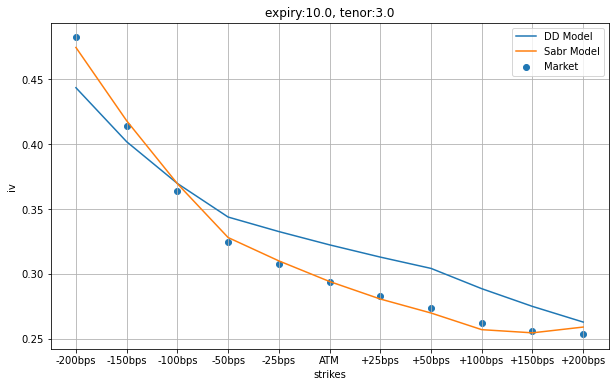

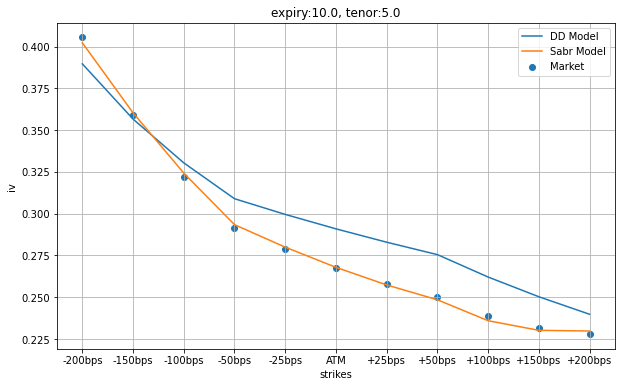

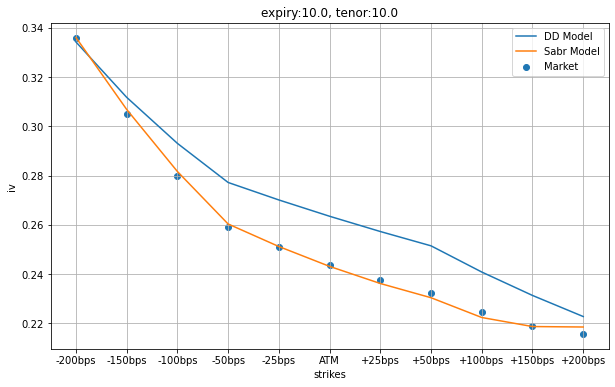

In [31]:
for i in range(len(data)):
    plt.figure(figsize = (10,6))
    plt.scatter(columns_fill,data.iloc[i][columns_fill]/100, label = 'Market', marker = 'o')
    plt.plot(columns_fill,df_dd_data.iloc[i][columns_fill],  label = 'DD Model' )
    plt.plot(columns_fill,df_sabr_data.iloc[i][columns_fill],  label = 'Sabr Model' )
    plt.xlabel('strikes')
    plt.ylabel('iv')
    plt.title('expiry:'+str(df_dd_data.iloc[i]['Expiry'])+', tenor:'+str(df_dd_data.iloc[i]['Tenor']))
    plt.legend()
    plt.grid()
    plt.show()